In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.cluster.hierarchy as sch
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.optimize import minimize

df = pd.read_csv("./Clean/clean-huf-spy-6.csv")
df = df.drop(columns=['Unnamed: 0'])
df.set_index('Dátum', inplace=True)
df = df[::-1]
df = df[df.index >= '2018-03-09']
annual_risk_free_rate = 0.02
daily_risk_free_rate = (1 + annual_risk_free_rate)**(1/252) - 1

benchmark = 'S&P 500'
# benchmark = 'USDHUF=X'
interesting = ['Citadella_Származtatott_Relative_Return', 'Erste_Stock_Hungary_Indexkövető_Részvény_A_Relative_Return',
               'SP500_Relative_Return', 'HOLD_Nemzetközi_Relative_Return', 'OTP_Supra_Relative_Return', 'HOLD_Columbus_Relative_Return']
# Create a dictionary to rename the columns to something simpler

rename_dict = {
    'Citadella_Származtatott': 'Citadella',
    'Erste_Stock_Hungary_Indexkövető_Részvény_A': 'Erste Indexkövető',
    'Generali_Arany_Oroszlán_ESG': 'Generali ESG',
    'HOLD_Columbus': 'HOLD Columbus',
    'HOLD_Nemzetközi': 'HOLD Nemzetközi',
    'HOLD_VM_Abszolút_Származtatott_Befektetési': 'HOLD Abszolút',
    'MBH_Fejlett_Piaci_Részvény': 'MBH Fejlett Piaci',
    'OTP_Klímaváltozás_13030': 'OTP Klímaváltozás',
    'OTP_Supra': 'OTP Supra',
    'VIG_Opportunity_Fejlett_Piaci_Részvény': 'VIG Opportunity',
    'Accorde_Abacus_Alap': 'Accord Abacus',
    'Accorde_Prizma_Alap': 'Accord Prizma',
    'HOLD_Orion': 'HOLD Orion',
    'OTP Föld Kincsei Árupiaci Alapok Alapja HUF': 'OTP Föld Kincsei',
    'Platina Delta Származtatott Befektetési Alap A':'Platina Delta',
    'Raiffeisen Részvény Alap':'Raiffeisen Részvény',
    'Takarék Származtatott Befektetési Alap': 'Gránit Takarék',
    'TakarékApolloSzármaztatottRészvény': 'Gránit Apollo',
    'SPY': 'S&P 500',
}

df_relative_returns = df.copy()
relative_return_columns = []
for column in df_relative_returns.columns:
    new_column = column + '_'
    df_relative_returns[column] = df_relative_returns[column] / df_relative_returns[column].iloc[0]
    
df=df_relative_returns
# df=df_relative_returns
df = df.rename(columns=rename_dict)

daily_returns = df.pct_change().dropna()


In [162]:
df

Accord Abacus  Accord Prizma       BUX  Citadella  \
Dátum                                                           
2018-03-09       1.000000       1.000000  1.000000   1.000000   
2018-03-12       1.003829       1.001205  1.010347   0.999769   
2018-03-13       1.002831       1.000461  1.006669   0.999737   
2018-03-14       1.001731       1.000750  1.012761   0.999947   
2018-03-19       1.008457       1.000947  0.981847   0.999093   
...                   ...            ...       ...        ...   
2024-08-08       1.838458       1.625783  1.821805   1.561106   
2024-08-09       1.837264       1.627478  1.824342   1.562690   
2024-08-12       1.842495       1.630228  1.832383   1.570898   
2024-08-13       1.840295       1.626572  1.819129   1.565224   
2024-08-14       1.843311       1.626204  1.814478   1.567576   

            Erste Indexkövető  Generali ESG  HOLD Columbus  HOLD Nemzetközi  \
Dátum                                                                         
2018-03-09           1.000000      1.000000       1.000000         1.000000   
2018-03-12           1.008766      1.003150       1.002696         1.000310   
2018-03-13           1.006094      0.994796       1.003100         0.992445   
2018-03-14           1.010453      0.992882       1.006085         0.988734   
2018-03-19           0.983875      0.992002       1.015453         0.982817   
...                       ...           ...            ...              ...   
2024-08-08           1.972390      1.763471       1.957978         2.306959   
2024-08-09           1.977172      1.759521       1.951828         2.307261   
2024-08-12           1.984062      1.752371       1.965931         2.305511   
2024-08-13           1.969437      1.757564       1.960089         2.325948   
2024-08-14           1.964703      1.770622       1.959663         2.327875   

            HOLD Orion  HOLD Abszolút  ...  Platina Delta  \
Dátum                                  ...                  
2018-03-09    1.000000       1.000000  ...       1.000000   
2018-03-12    0.999920       0.999815  ...       1.002337   
2018-03-13    0.999893       0.999745  ...       0.997683   
2018-03-14    0.999866       0.999467  ...       0.997159   
2018-03-19    0.999732       1.000874  ...       0.989766   
...                ...            ...  ...            ...   
2024-08-08    2.087016       1.337058  ...       2.698453   
2024-08-09    2.081122       1.338061  ...       2.702275   
2024-08-12    2.097733       1.338330  ...       2.711484   
2024-08-13    2.086246       1.339318  ...       2.716088   
2024-08-14    2.083206       1.338393  ...       2.697433   

            Raiffeisen Részvény  Gránit Takarék  Gránit Apollo  \
Dátum                                                            
2018-03-09             1.000000        1.000000       1.000000   
2018-03-12             1.004982        0.999657       1.001650   
2018-03-13             1.012614        0.999642       0.993494   
2018-03-14             1.006557        0.999621       0.988882   
2018-03-19             1.002323        0.999459       0.982259   
...                         ...             ...            ...   
2024-08-08             1.765225        1.208225       1.919798   
2024-08-09             1.764682        1.208991       1.923306   
2024-08-12             1.760517        1.212594       1.925606   
2024-08-13             1.782071        1.212322       1.934929   
2024-08-14             1.778572        1.212669       1.940416   

            VIG Opportunity   S&P 500       QQQ       VGT     BRK-B  USDHUF=X  
Dátum                                                                          
2018-03-09         1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
2018-03-12         1.001293  0.998141  1.004706  1.002921  0.994139  0.999396  
2018-03-13         0.992982  0.990017  0.989355  0.989103  0.979858  0.997709  
2018-03-14         0.987349  0.980103  0.984327  0.984463  0.965071  0.992812  
2018-

In [163]:
fee_structure = {
    "Gránit Apollo": {
        "entry_fee_percent": 3.0,
        "exit_fee_percent": 3.0,
        "management_fee_percent": 1.97
    },
    "Erste Indexkövető": {
        "entry_fee_percent": 2.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 0.99,
        "portfolio_transaction_fee_percent": 0.26
    },
    "Generali ESG": {
        "entry_fee_percent": 3.0,
        "exit_fee_percent": 1.5,
        "management_fee_percent": 1.95,
        "transaction_fee_percent": 0.07,
        "performance_fee_percent": 0.0
    },
    "MBH Fejlett Piaci": {
        "entry_fee_percent": 2.22,
        "exit_fee_percent": 0.1,
        "management_fee_percent": 2.24,
        "transaction_fee_percent": 0.1,
        "performance_fee_percent": 0.0
    },
    "OTP Klímaváltozás": {
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 5.0,
        "management_fee_percent": 2.14,
        "transaction_fee_percent": 0.3,
        "performance_fee_percent": 1.23
    },
    "OTP Supra": {
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 5.0,
        "management_fee_percent": 2.21,
        "transaction_fee_percent": 0.84,
        "performance_fee_percent": 1.02
    },
    "HOLD Columbus": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.19,
        "transaction_fee_percent": 0.12,
        "performance_fee_percent": 0.02
    },
    "HOLD Nemzetközi": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 1.33,
        "transaction_fee_percent": 0.1,
        "performance_fee_percent": 0.0
    },
    "HOLD Abszolút": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 1.88,
        "transaction_fee_percent": 0.12,
        "performance_fee_percent": 0.67
    },
    "HOLD Orion": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.20,
        "transaction_fee_percent": 0.22,
        "performance_fee_percent": 0.01,
    },
    "VIG Opportunity": {  # bad
        "entry_fee_percent": 5.0,
        "exit_fee_percent": 3.5,
        "management_fee_percent": 1.92,
        "transaction_fee_percent": 0.11,
        "performance_fee_percent": 0.01,
    },
    "Accord Prizma": {
        "entry_fee_percent": 1.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.09,
        "transaction_fee_percent": 0.0002,
        "performance_fee_percent": 1.59,
    },
    "Platina Delta": {
        "entry_fee_percent": 0.0,
        "exit_fee_percent": 0.0,
        "management_fee_percent": 2.20,
        "transaction_fee_percent": 0.22,
        "performance_fee_percent": 0.01,
    },
    "Citadella": {
    "entry_fee_percent": 0.0,
    "exit_fee_percent": 0.0,
    "management_fee_percent": 1.88,
    "transaction_fee_percent": 0.08,
    "performance_fee_percent": 1.55,
    "management_fee_huf": 75394,  # Estimated annual management fee
    "transaction_fee_huf": 3336,  # Estimated annual transaction fee
    "performance_fee_huf": 62000  # Estimated performance fee
    },
}


In [164]:
good_secus = list(fee_structure.keys()) + [benchmark]
df = df[good_secus]
daily_returns = daily_returns[good_secus]

In [165]:
df['Citadella']

Dátum
2018-03-09    1.000000
2018-03-12    0.999769
2018-03-13    0.999737
2018-03-14    0.999947
2018-03-19    0.999093
                ...   
2024-08-08    1.561106
2024-08-09    1.562690
2024-08-12    1.570898
2024-08-13    1.565224
2024-08-14    1.567576
Name: Citadella, Length: 1544, dtype: float64

In [166]:
def apply_fees(df_returns, security_name):
    # Retrieve fees for the given security
    fees = fee_structure.get(security_name, None)
    if fees is None:
        raise ValueError(f"Fee structure for {security_name} not found.")

    # Apply entry transaction fee at the start
    entry_fee_percent = fees['entry_fee_percent'] / 100
    df_returns.iloc[0] -= entry_fee_percent
    print(f"Entry fee applied on {df_returns.index[0]}: {entry_fee_percent * 100}%")
    
    # Track the end of each year
    last_year = pd.to_datetime(df_returns.index[0], format='%Y-%m-%d').year
    
    for i in range(1, len(df_returns)):
        current_year = pd.to_datetime(df_returns.index[i], format='%Y-%m-%d').year
        
        # Apply fees only once per year
        if current_year != last_year:
            # Apply management fees
            management_fee_percent = fees['management_fee_percent'] / 100
            df_returns.iloc[i] -= management_fee_percent
            print(f"Management fee applied on {df_returns.index[i]}: {management_fee_percent * 100}%")
            
            # Apply performance fee if it exists and if the return is positive
            if 'performance_fee_percent' in fees and fees['performance_fee_percent'] > 0:
                performance_fee_percent = fees['performance_fee_percent'] / 100
                df_returns.iloc[i] -= performance_fee_percent
                print(f"Performance fee applied on {df_returns.index[i]}: {performance_fee_percent * 100}% of excess return")
            
            last_year = current_year
    
    # Apply exit transaction fee at the end
    exit_fee_percent = fees['exit_fee_percent'] / 100
    df_returns.iloc[-1] -= exit_fee_percent
    print(f"Exit fee applied on {df_returns.index[-1]}: {exit_fee_percent * 100}%")
    
    return df_returns

# Applying the function to the relative time series with the fees of Citadella
for col in daily_returns.columns:
    print(col)
    if col in fee_structure:
        print(col)
        daily_returns[col] = apply_fees(daily_returns[col], security_name=col)
df_fee = (daily_returns+1).cumprod()



Gránit Apollo
Gránit Apollo
Entry fee applied on 2018-03-12: 3.0%
Management fee applied on 2019-01-02: 1.97%
Management fee applied on 2020-01-02: 1.97%
Management fee applied on 2021-01-04: 1.97%
Management fee applied on 2022-01-03: 1.97%
Management fee applied on 2023-01-03: 1.97%
Management fee applied on 2024-01-02: 1.97%
Exit fee applied on 2024-08-14: 3.0%
Erste Indexkövető
Erste Indexkövető
Entry fee applied on 2018-03-12: 2.0%
Management fee applied on 2019-01-02: 0.9899999999999999%
Management fee applied on 2020-01-02: 0.9899999999999999%
Management fee applied on 2021-01-04: 0.9899999999999999%
Management fee applied on 2022-01-03: 0.9899999999999999%
Management fee applied on 2023-01-03: 0.9899999999999999%
Management fee applied on 2024-01-02: 0.9899999999999999%
Exit fee applied on 2024-08-14: 0.0%
Generali ESG
Generali ESG
Entry fee applied on 2018-03-12: 3.0%
Management fee applied on 2019-01-02: 1.95%
Management fee applied on 2020-01-02: 1.95%
Management fee applied

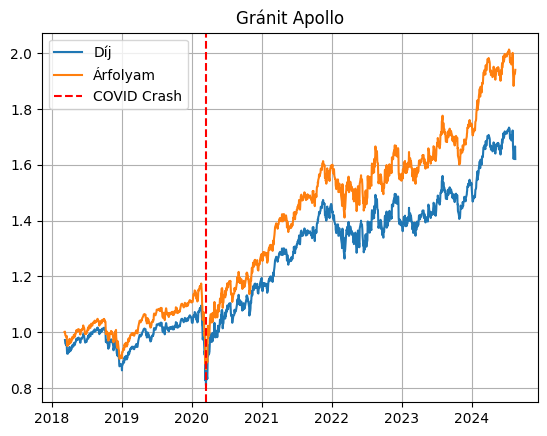

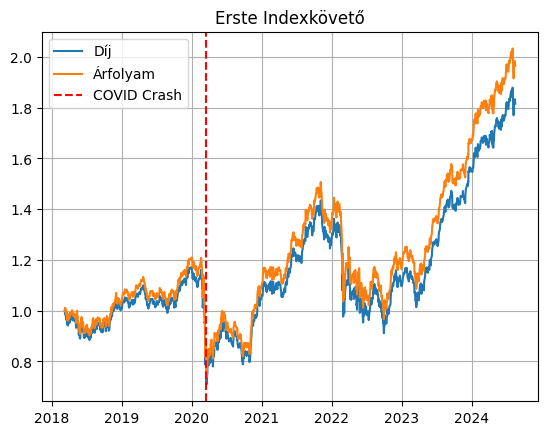

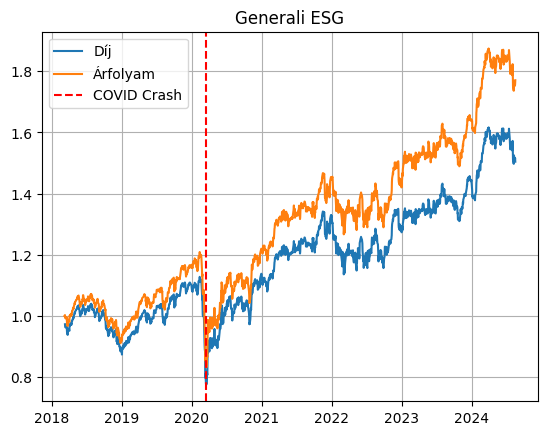

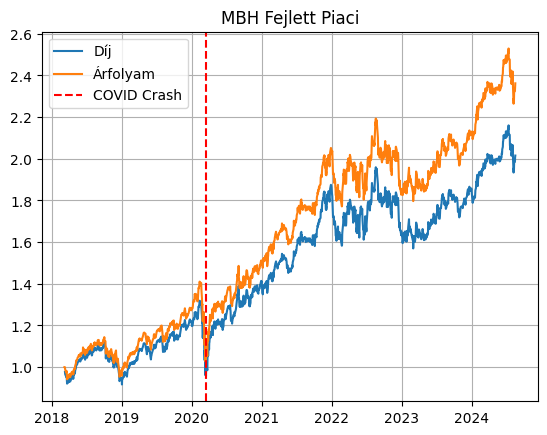

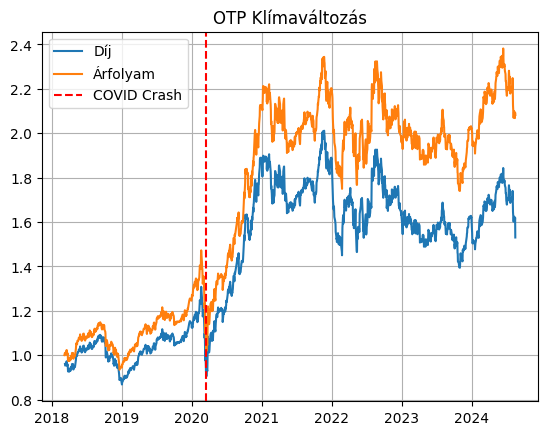

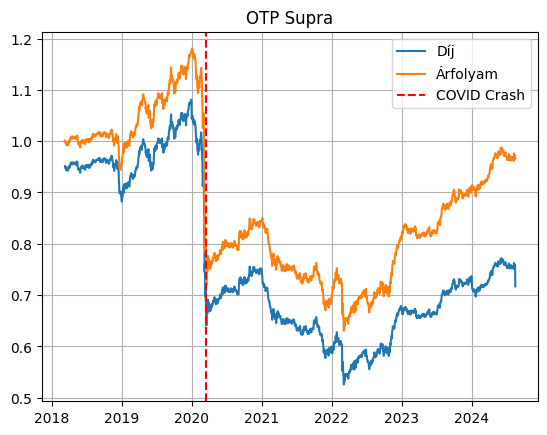

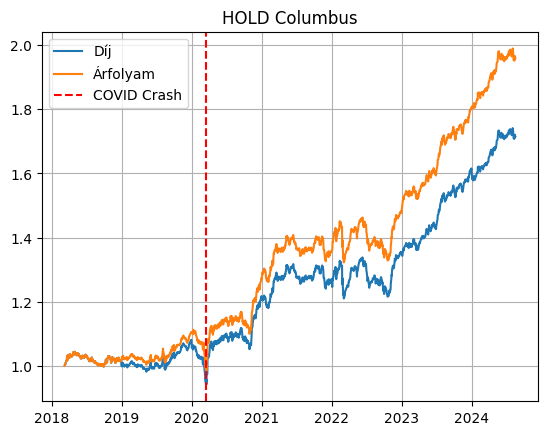

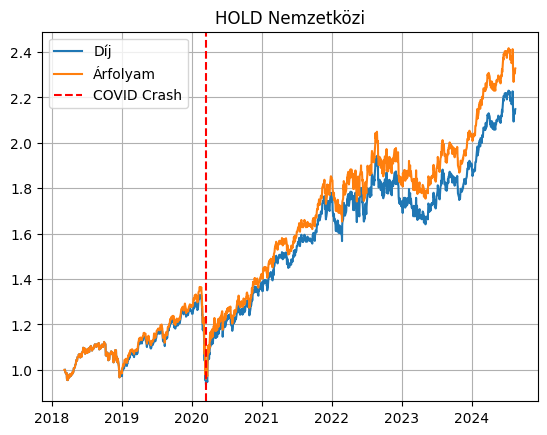

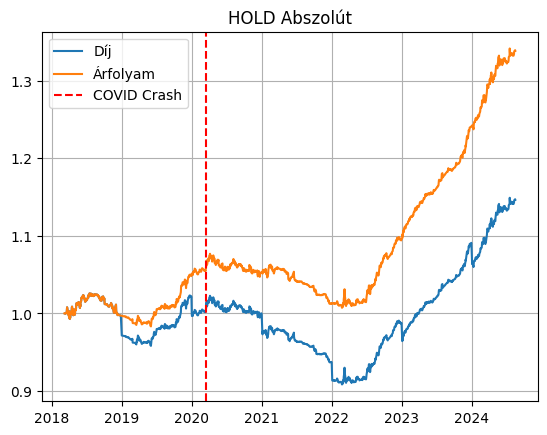

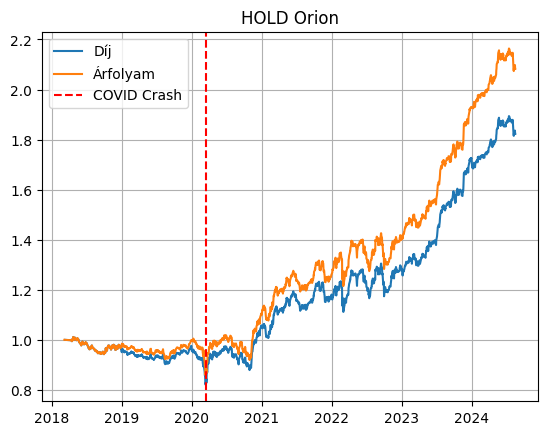

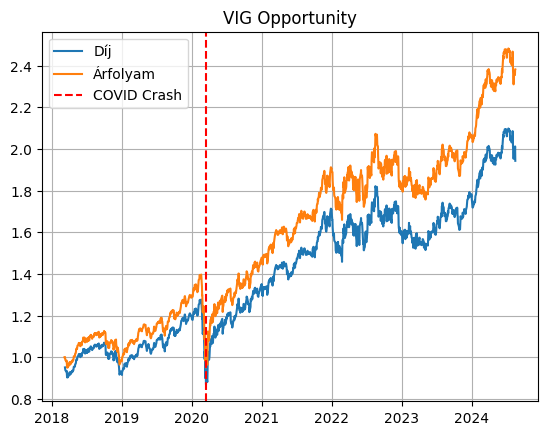

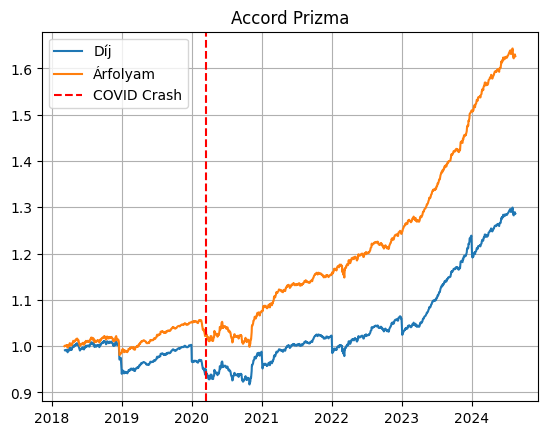

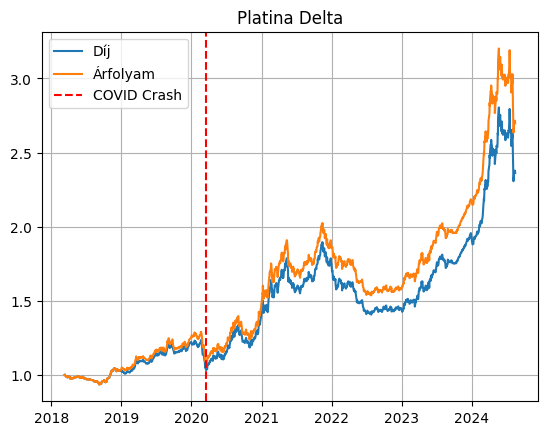

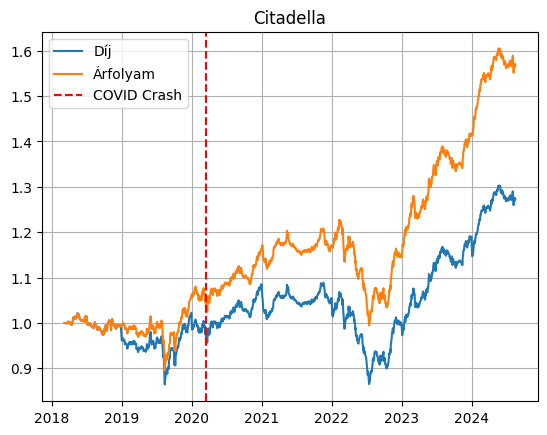

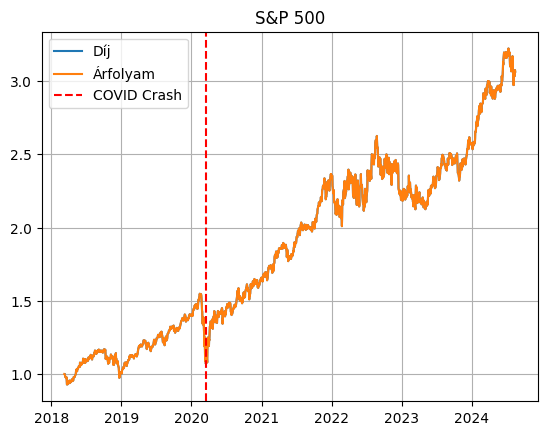

In [167]:
for col in df_fee.columns:
    plt.plot(pd.to_datetime(df_fee.index), df_fee[col], label='Díj')
    plt.plot(pd.to_datetime(df.index), df[col], label='Árfolyam')

    plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')
    plt.title(col)
    # plt.xlabel(x_label)
    plt.legend()
    # plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

In [168]:
df = df_fee

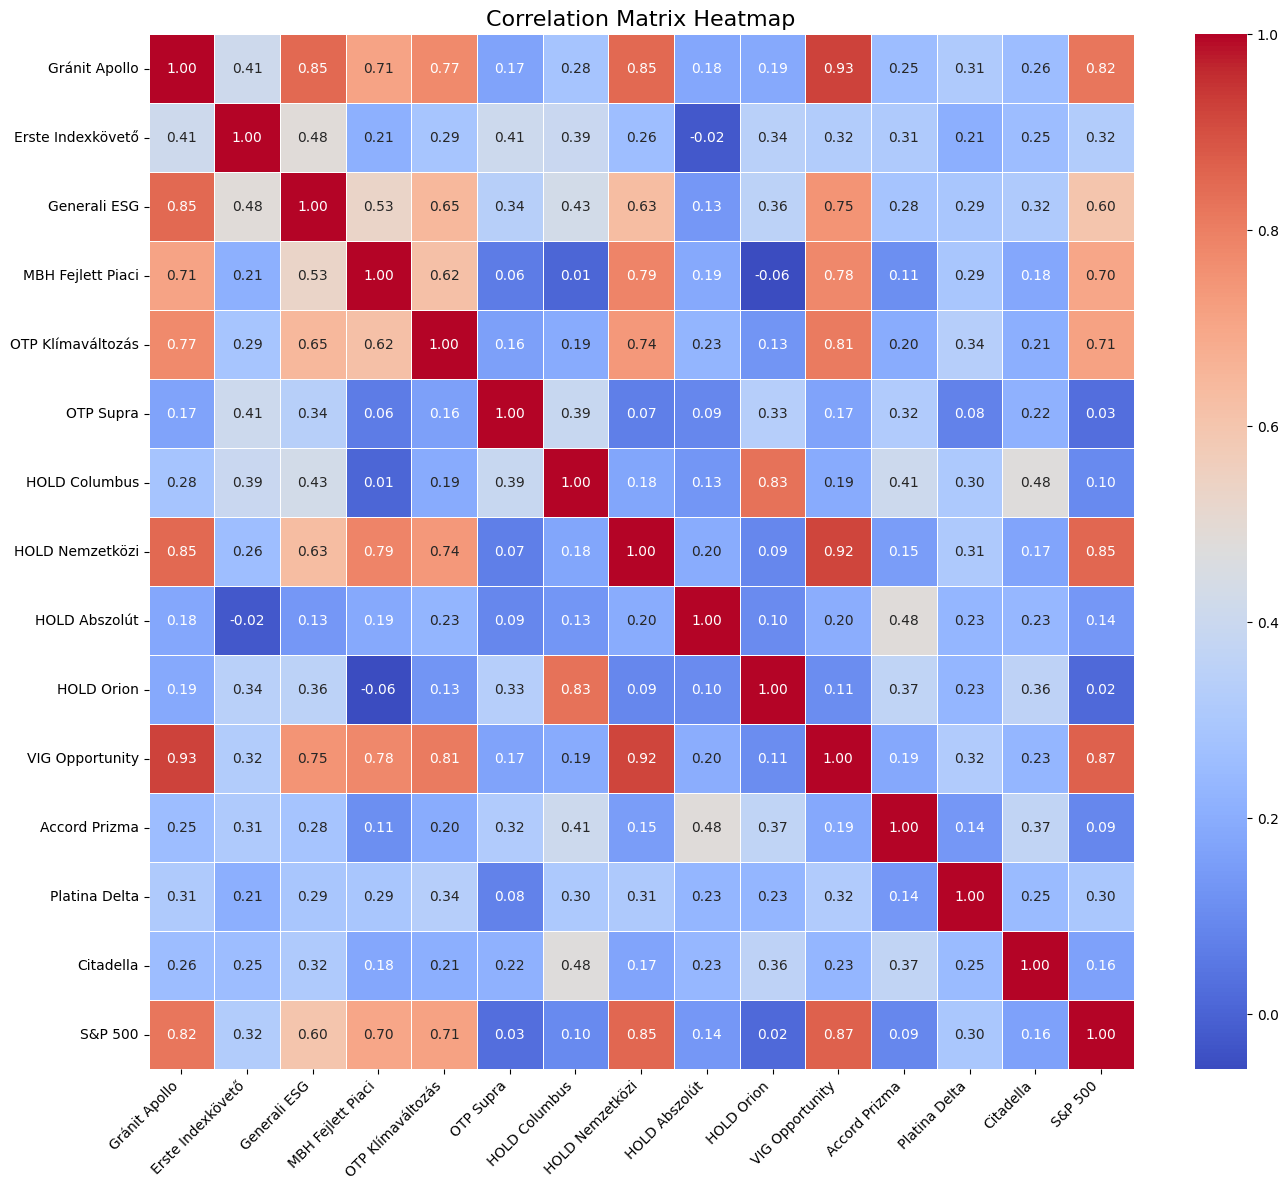

In [169]:
correlation_matrix = daily_returns.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

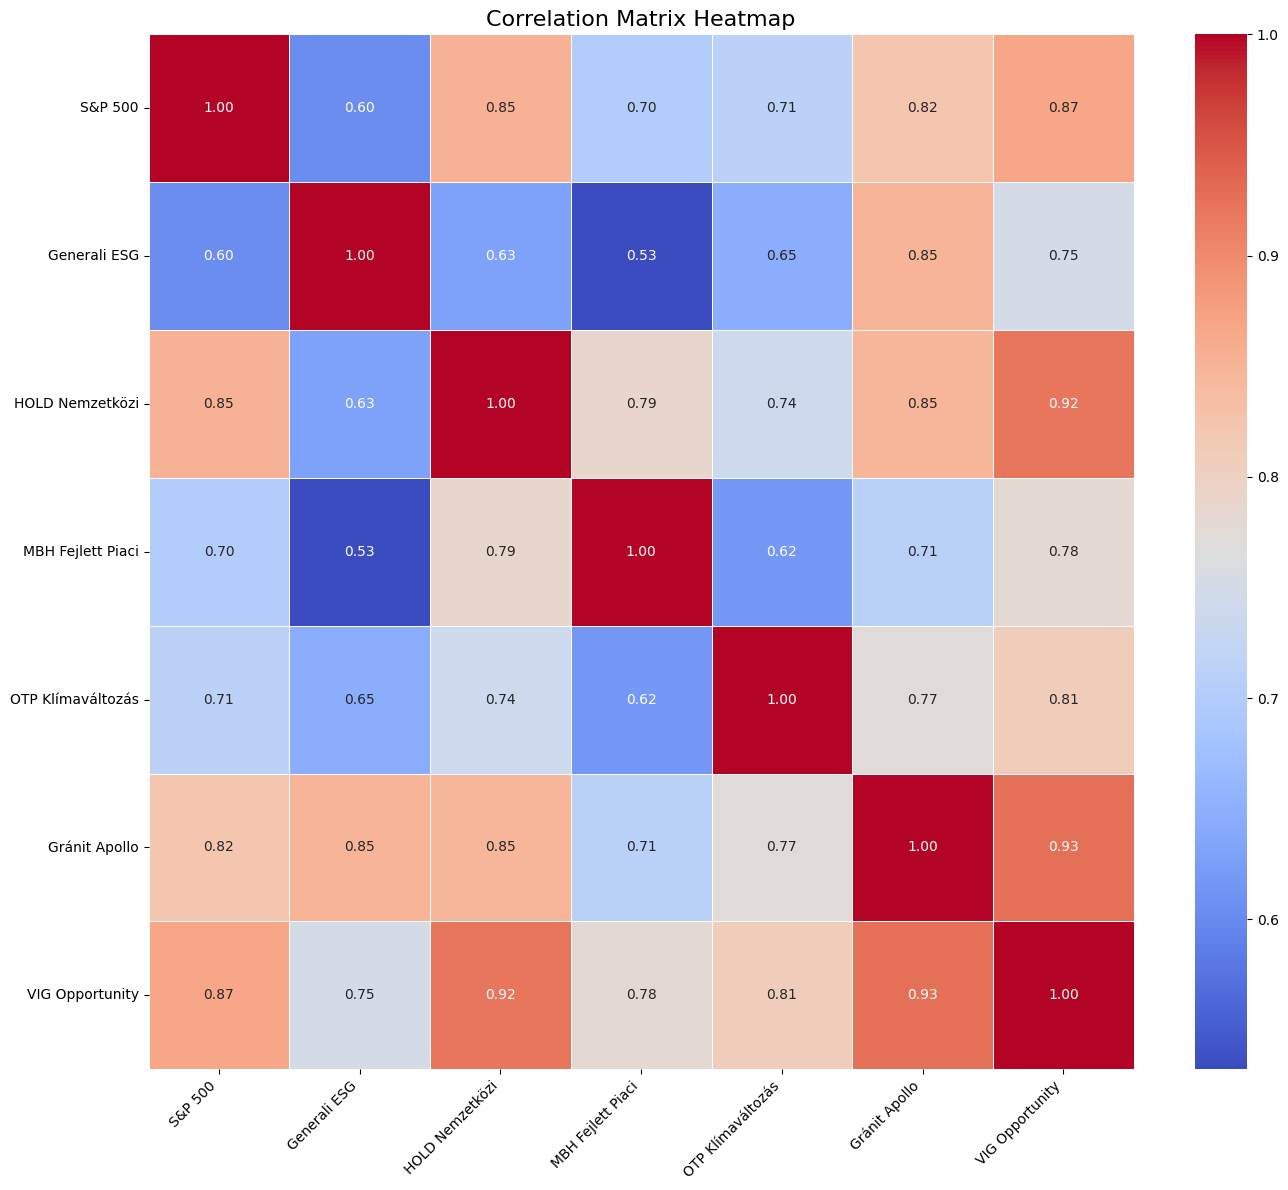

In [170]:
spy_correlated = ['S&P 500','Generali ESG', 'HOLD Nemzetközi', 'MBH Fejlett Piaci', 'OTP Klímaváltozás', 'Gránit Apollo','VIG Opportunity'  ]
correlation_matrix = daily_returns[spy_correlated].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

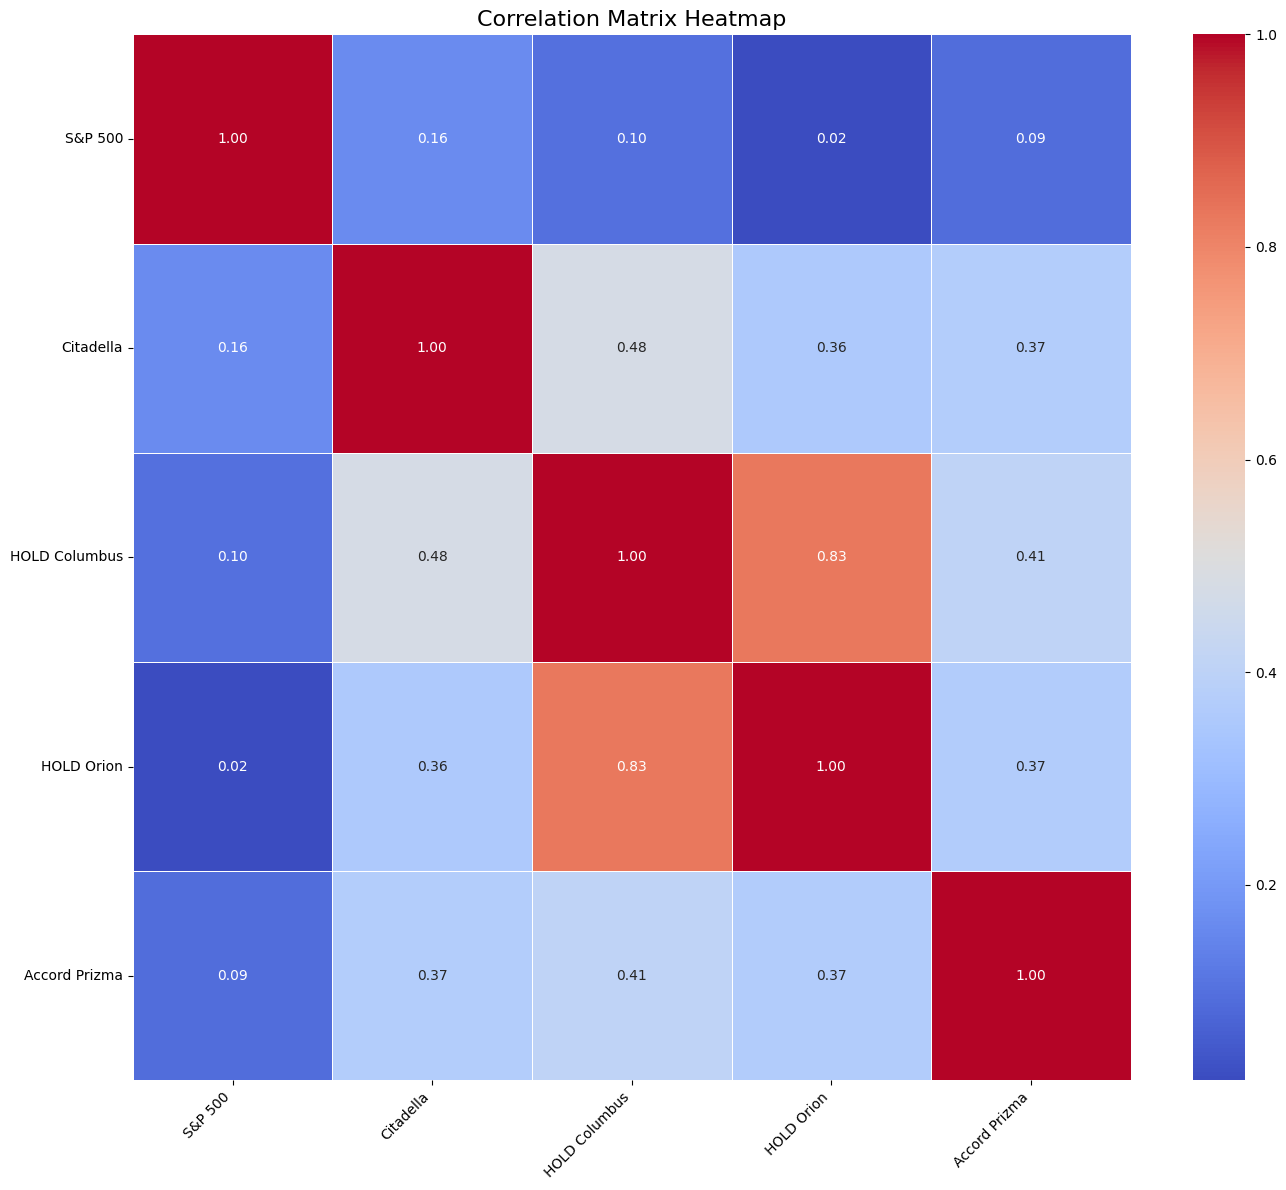

In [171]:
spy_correlated = ['S&P 500','Citadella', 'HOLD Columbus','HOLD Orion','Accord Prizma', ]
correlation_matrix = daily_returns[spy_correlated].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [172]:
def draw_decreasing_barchart(data, title, x_label, y_label):
    data = data.sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    data.plot(kind='bar', color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
def draw_linchart(data, title, x_label, y_label):
    
    plt.figure(figsize=(12, 8))
    for column in data.columns:
        plt.plot(pd.to_datetime(data.index), data[column], label=column)

    plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')
    plt.title(title)
    plt.xlabel(x_label)
    plt.legend()
    plt.ylabel(y_label)
    plt.grid(True)
    plt.show()

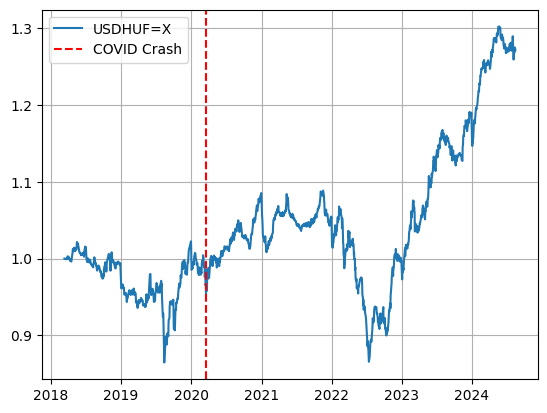

In [173]:
plt.plot(pd.to_datetime(df.index), df['Citadella'], label=column)

plt.axvline(pd.to_datetime('2020-03-16'), color='red', linestyle='--', label='COVID Crash')
# plt.title(title)
# plt.xlabel(x_label)
plt.legend()
# plt.ylabel(y_label)
plt.grid(True)
plt.show()

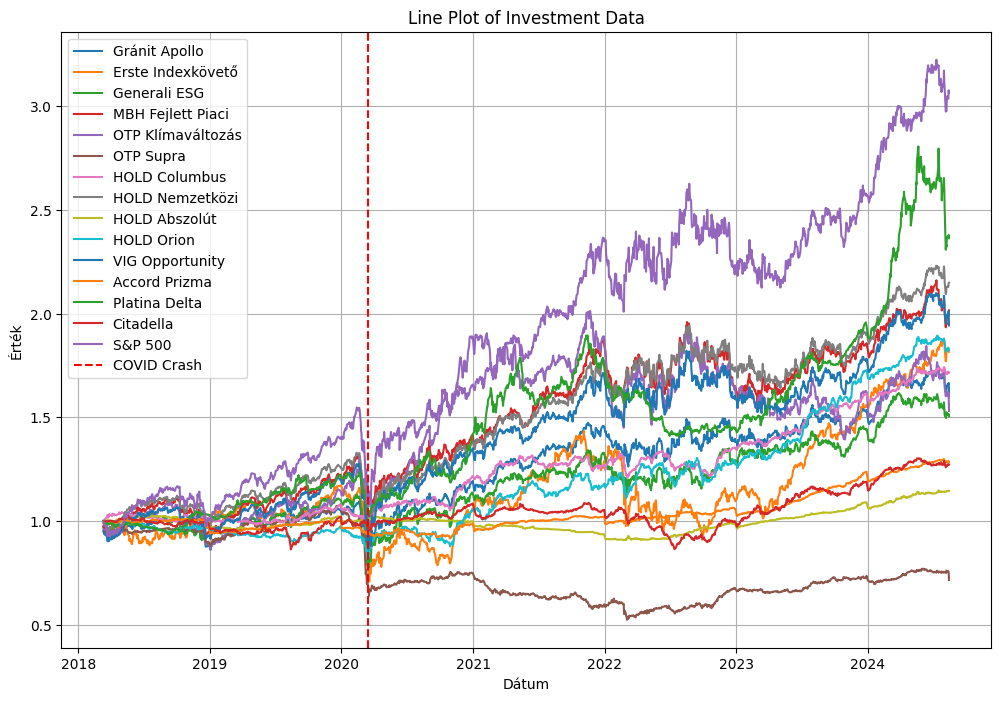

In [174]:
draw_linchart(df, 'Line Plot of Investment Data', 'Dátum', 'Érték' )

In [175]:
average_daily_returns = daily_returns.mean()
excess_returns = daily_returns - daily_risk_free_rate
std_dev_returns = daily_returns.std()
sharpe_ratios_daily = average_daily_returns / std_dev_returns
sharpe_ratios_annualized = sharpe_ratios_daily * np.sqrt(252)
sharpe_ratios_df = pd.DataFrame({
    'Average Daily Return': average_daily_returns,
    'Standard Deviation of Returns': std_dev_returns,
    'Daily Sharpe Ratio': sharpe_ratios_daily,
    'Annualized Sharpe Ratio': sharpe_ratios_annualized
})
sharpe_ratios_df

Average Daily Return  Standard Deviation of Returns  \
Gránit Apollo                  0.000369                       0.010576   
Erste Indexkövető              0.000484                       0.013878   
Generali ESG                   0.000322                       0.010737   
MBH Fejlett Piaci              0.000526                       0.011935   
OTP Klímaváltozás              0.000374                       0.014014   
OTP Supra                     -0.000179                       0.008492   
HOLD Columbus                  0.000363                       0.005232   
HOLD Nemzetközi                0.000562                       0.011464   
HOLD Abszolút                  0.000091                       0.002404   
HOLD Orion                     0.000414                       0.006966   
VIG Opportunity                0.000505                       0.012220   
Accord Prizma                  0.000168                       0.002999   
Platina Delta                  0.000595                       0.008710   
Citadella                      0.000169                       0.005113   
S&P 500                        0.000833                       0.014626   

                   Daily Sharpe Ratio  Annualized Sharpe Ratio  
Gránit Apollo                0.034884                 0.553764  
Erste Indexkövető            0.034875                 0.553620  
Generali ESG                 0.030036                 0.476808  
MBH Fejlett Piaci            0.044036                 0.699052  
OTP Klímaváltozás            0.026701                 0.423864  
OTP Supra                   -0.021046                -0.334092  
HOLD Columbus                0.069456                 1.102582  
HOLD Nemzetközi              0.048990                 0.777694  
HOLD Abszolút                0.038037                 0.603812  
HOLD Orion                   0.059372                 0.942502  
VIG Opportunity              0.041364                 0.656629  
Accord Prizma                0.055891                 0.887243  
Platina Delta                0.068358                 1.085153  
Citadella                    0.033112                 0.525630  
S&P 500                      0.056965                 0.904292

Sortino Ratios:
 Gránit Apollo        0.567992
Erste Indexkövető    0.550020
Generali ESG         0.469796
MBH Fejlett Piaci    0.783407
OTP Klímaváltozás    0.452279
OTP Supra           -0.489004
HOLD Columbus        1.164043
HOLD Nemzetközi      0.867382
HOLD Abszolút        0.084358
HOLD Orion           1.043736
VIG Opportunity      0.697039
Accord Prizma        0.408597
Platina Delta        1.177126
Citadella            0.336739
S&P 500              1.074700
dtype: float64


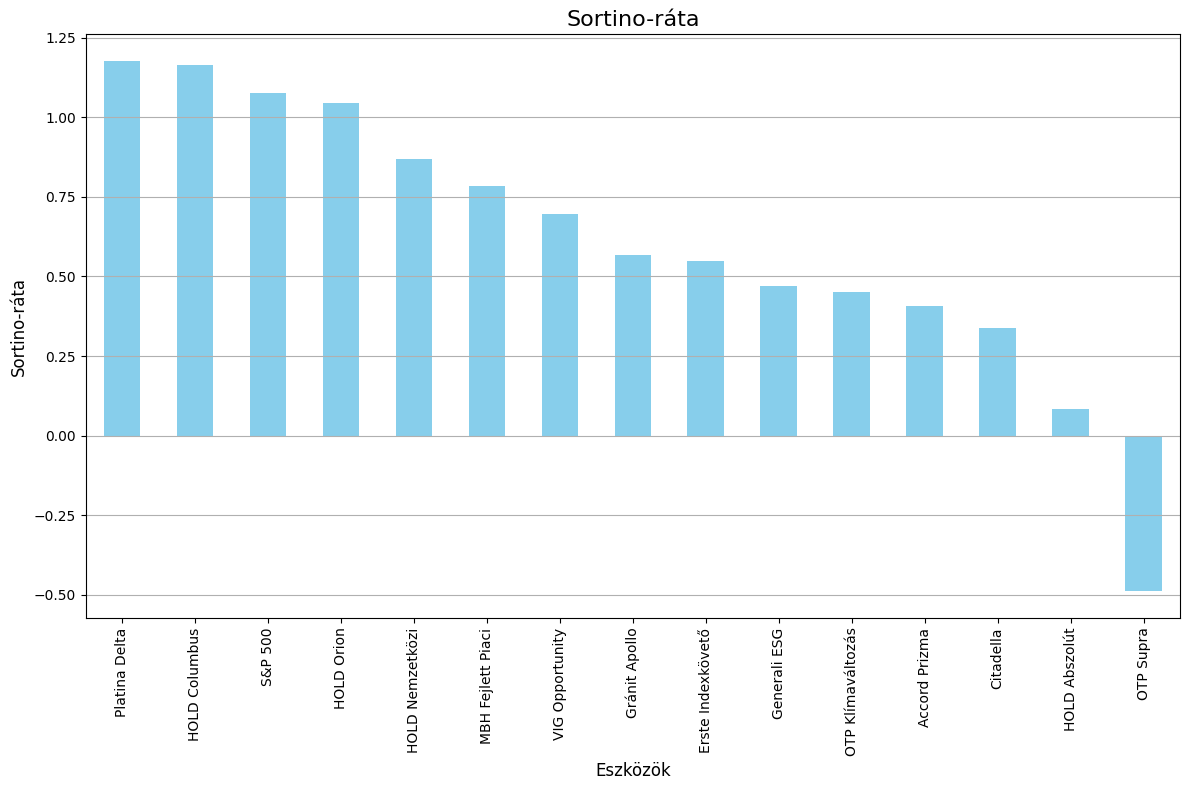

Treynor Ratios:
 Gránit Apollo        0.000488
Erste Indexkövető    0.001329
Generali ESG         0.000550
MBH Fejlett Piaci    0.000781
OTP Klímaváltozás    0.000433
OTP Supra           -0.015559
HOLD Columbus        0.008037
HOLD Nemzetközi      0.000722
HOLD Abszolút        0.000571
HOLD Orion           0.043510
VIG Opportunity      0.000589
Accord Prizma        0.004726
Platina Delta        0.002933
Citadella            0.001579
S&P 500              0.000754
dtype: float64


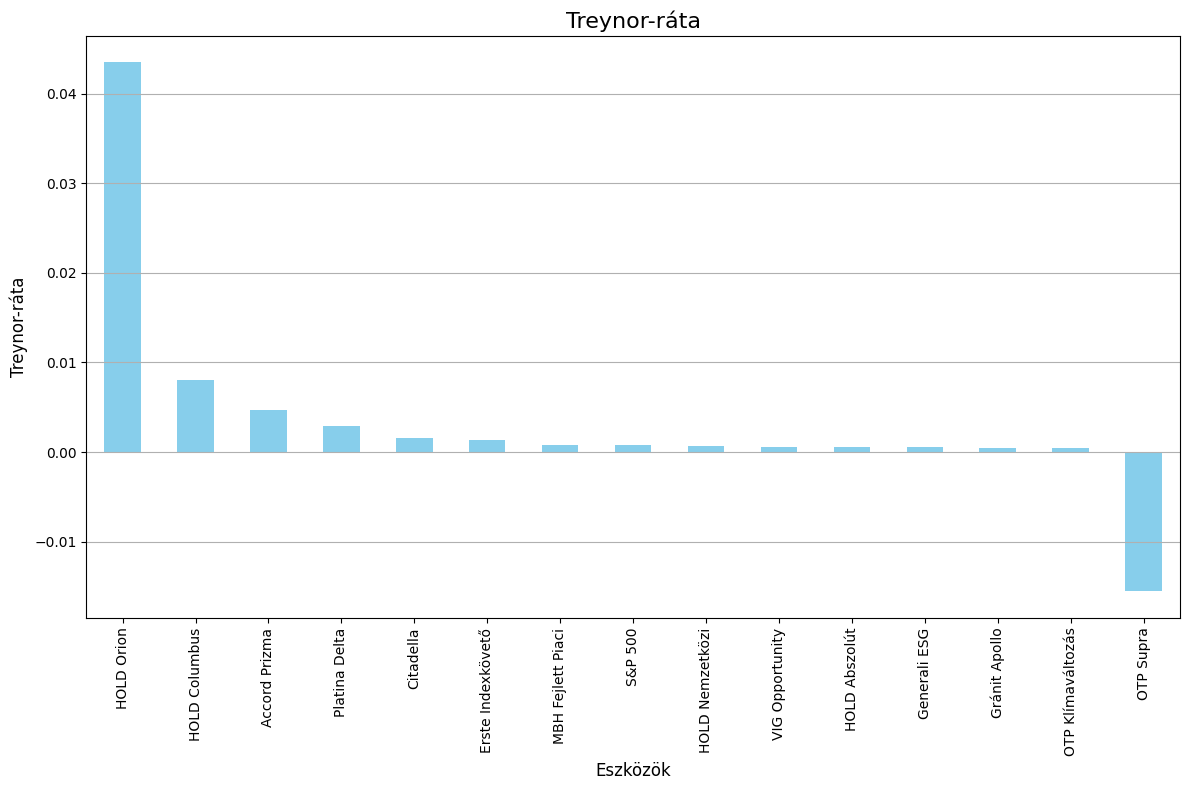

In [176]:
def sortino_ratio(returns, target=0):
    excess_returns = returns - target
    downside_deviation = np.std(excess_returns[excess_returns < target])
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    sortino_ratio_annualized = sortino_ratio * np.sqrt(252)
    
    return sortino_ratio_annualized
sortino_ratios = daily_returns.apply(sortino_ratio, target=daily_risk_free_rate)
print("Sortino Ratios:\n", sortino_ratios)
draw_decreasing_barchart(sortino_ratios, 'Sortino-ráta', 'Eszközök', 'Sortino-ráta')

def treynor_ratio(returns, market_returns, beta, daily_risk_free_rate):
    excess_returns = np.mean(returns) - daily_risk_free_rate
    treynor_ratio = excess_returns / beta
    return treynor_ratio

market_returns = daily_returns[benchmark]
betas = daily_returns.apply(lambda x: np.cov(x, market_returns)[0, 1] / np.var(market_returns))
treynor_ratios = daily_returns.apply(lambda x: treynor_ratio(x, market_returns, betas[x.name], daily_risk_free_rate))
print("Treynor Ratios:\n", treynor_ratios)
draw_decreasing_barchart(treynor_ratios, 'Treynor-ráta', 'Eszközök', 'Treynor-ráta')


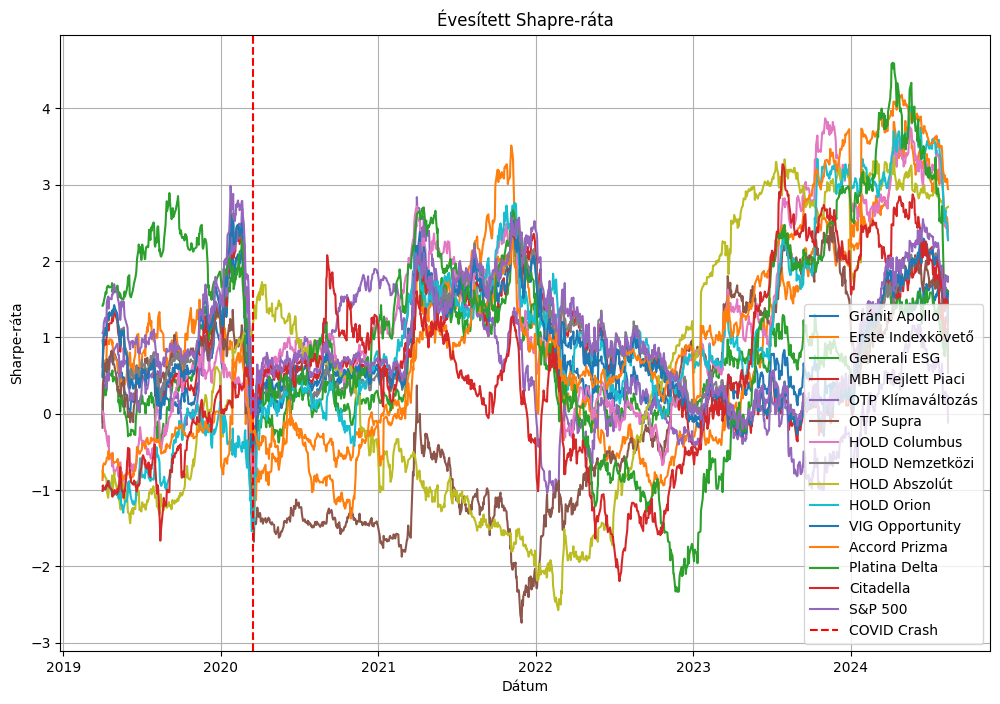

In [177]:
window_size = 252
rolling_sharpe_ratios = (
    daily_returns.rolling(window=window_size).mean() / 
    daily_returns.rolling(window=window_size).std()
) * np.sqrt(252)
draw_linchart(rolling_sharpe_ratios, 'Évesített Shapre-ráta', 'Dátum', 'Sharpe-ráta')


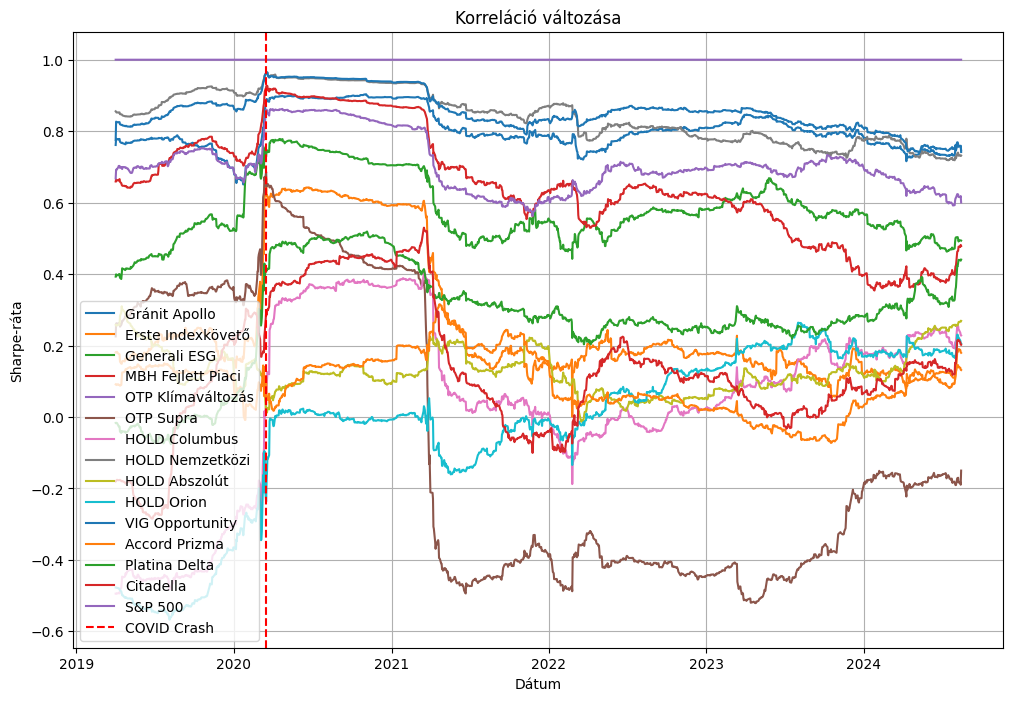

In [178]:
rolling_correlations = daily_returns.rolling(window=window_size).corr(daily_returns[benchmark])
draw_linchart(rolling_correlations, 'Korreláció változása', 'Dátum', 'Sharpe-ráta')


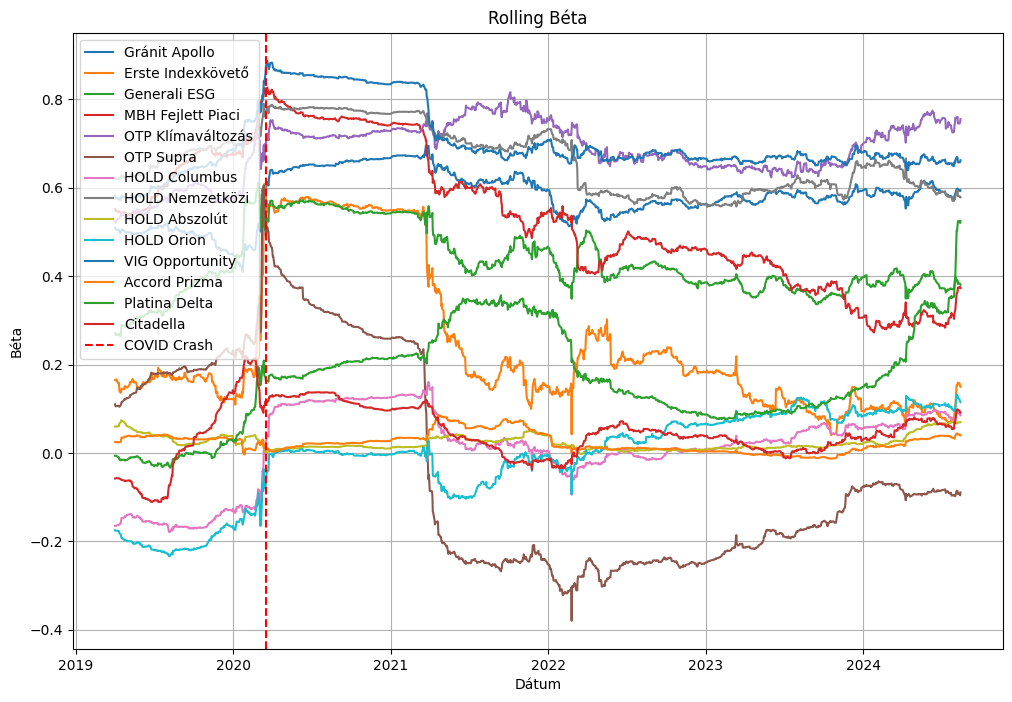

In [179]:
benchmark_returns = daily_returns[benchmark]
window_size = 252
betas = pd.DataFrame(index=daily_returns.index)
for column in daily_returns.columns:
    if column != benchmark: 
        rolling_covariance = daily_returns[column].rolling(window=window_size).cov(benchmark_returns)
        rolling_variance = benchmark_returns.rolling(window=window_size).var()
        rolling_beta = rolling_covariance / rolling_variance
        betas[column] = rolling_beta    
draw_linchart(betas, 'Rolling Béta', 'Dátum', 'Béta')


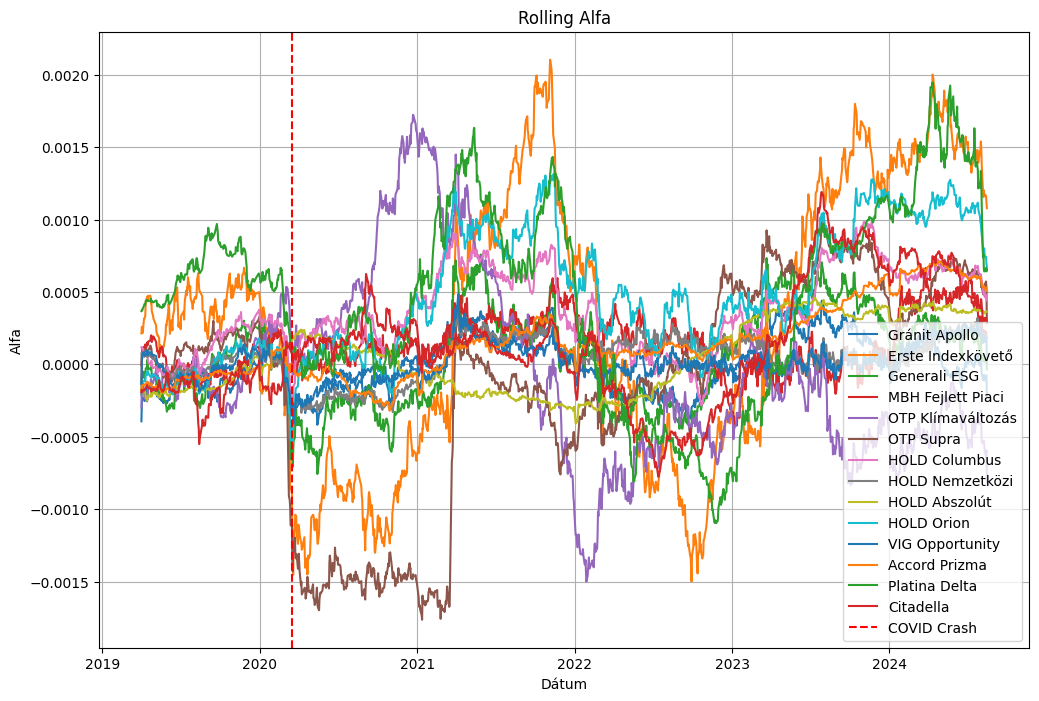

In [180]:
alphas = pd.DataFrame(index=daily_returns.index)
for column in daily_returns.columns:
    if column != benchmark:  # Skip the benchmark itself
        rolling_covariance = daily_returns[column].rolling(window=window_size).cov(benchmark_returns)
        rolling_variance = benchmark_returns.rolling(window=window_size).var()
        rolling_beta = rolling_covariance / rolling_variance
        expected_returns = rolling_beta * (benchmark_returns.rolling(window=window_size).mean() - daily_risk_free_rate)
        rolling_alpha = daily_returns[column].rolling(window=window_size).mean() - expected_returns
        alphas[column] = rolling_alpha
draw_linchart(alphas, 'Rolling Alfa', 'Dátum', 'Alfa')

HOLD Orion           0.000482
Platina Delta        0.000465
HOLD Columbus        0.000361
Erste Indexkövető    0.000297
Accord Prizma        0.000143
MBH Fejlett Piaci    0.000138
Citadella            0.000133
Generali ESG         0.000046
HOLD Abszolút        0.000046
HOLD Nemzetközi      0.000043
VIG Opportunity      0.000017
Gránit Apollo        0.000003
OTP Klímaváltozás   -0.000046
OTP Supra           -0.000142
dtype: float64


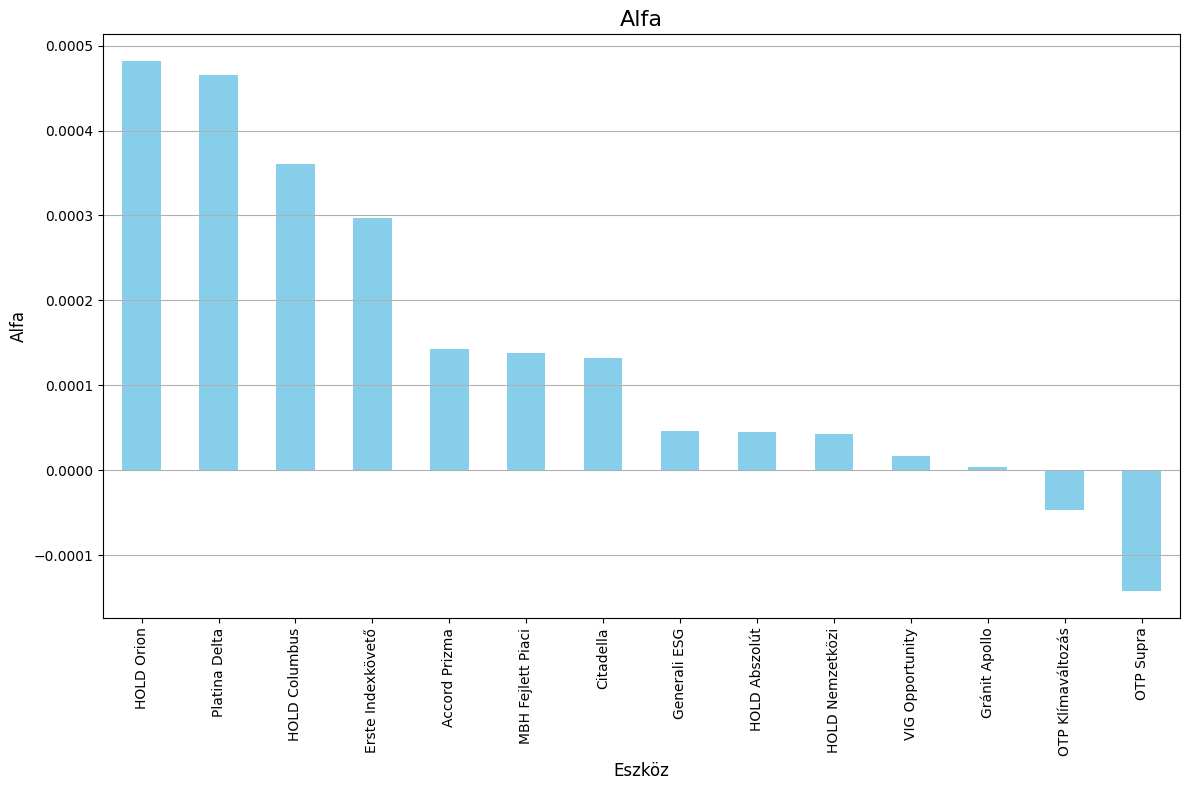

In [181]:
mean_alphas = alphas.mean()
mean_alphas = mean_alphas.sort_values(ascending=False)
print(mean_alphas)
draw_decreasing_barchart(mean_alphas, 'Alfa', 'Eszköz', 'Alfa')

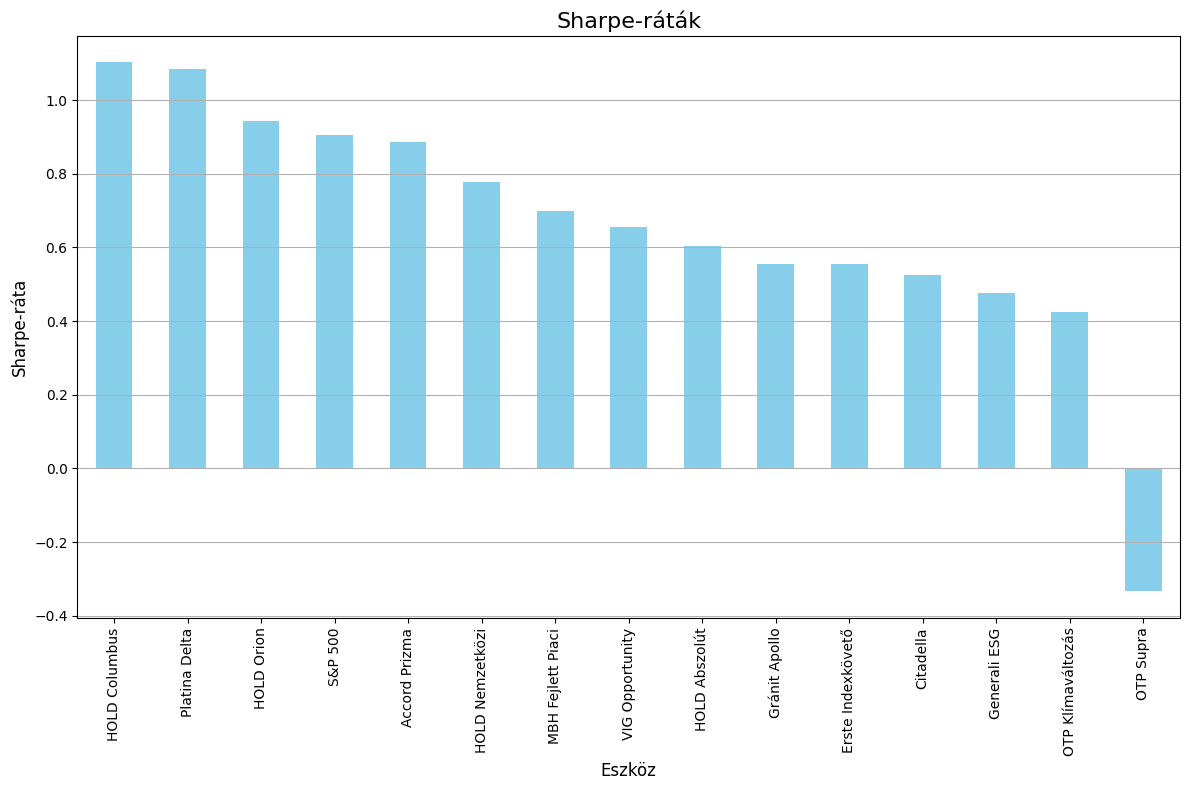

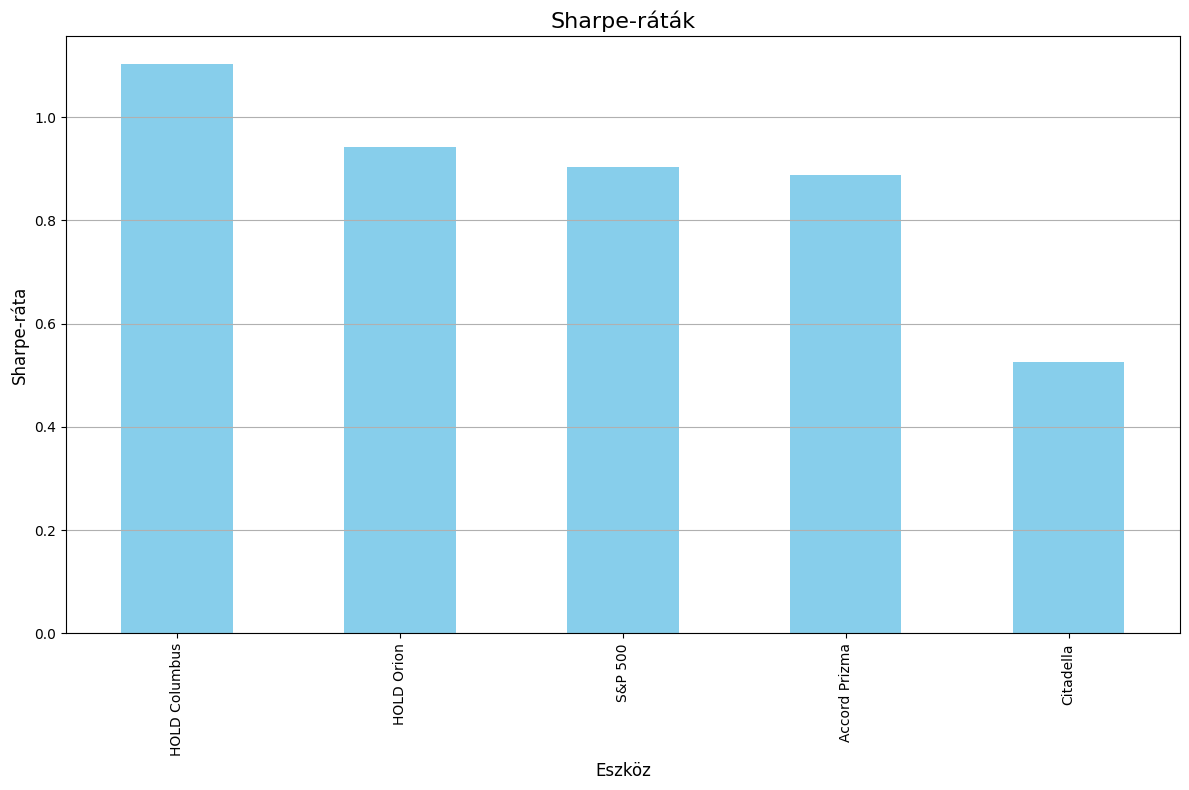

In [182]:
# Sort the Sharpe Ratios in descending order for the bar chart
sorted_sharpe_ratios = sharpe_ratios_df['Annualized Sharpe Ratio'].sort_values(ascending=False)
draw_decreasing_barchart(sorted_sharpe_ratios, 'Sharpe-ráták', 'Eszköz', 'Sharpe-ráta')

draw_decreasing_barchart(sorted_sharpe_ratios[spy_correlated], 'Sharpe-ráták', 'Eszköz', 'Sharpe-ráta')


C:\Users\takat\AppData\Local\Temp\ipykernel_33328\3352012754.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = sch.linkage(distance_matrix, method='average')


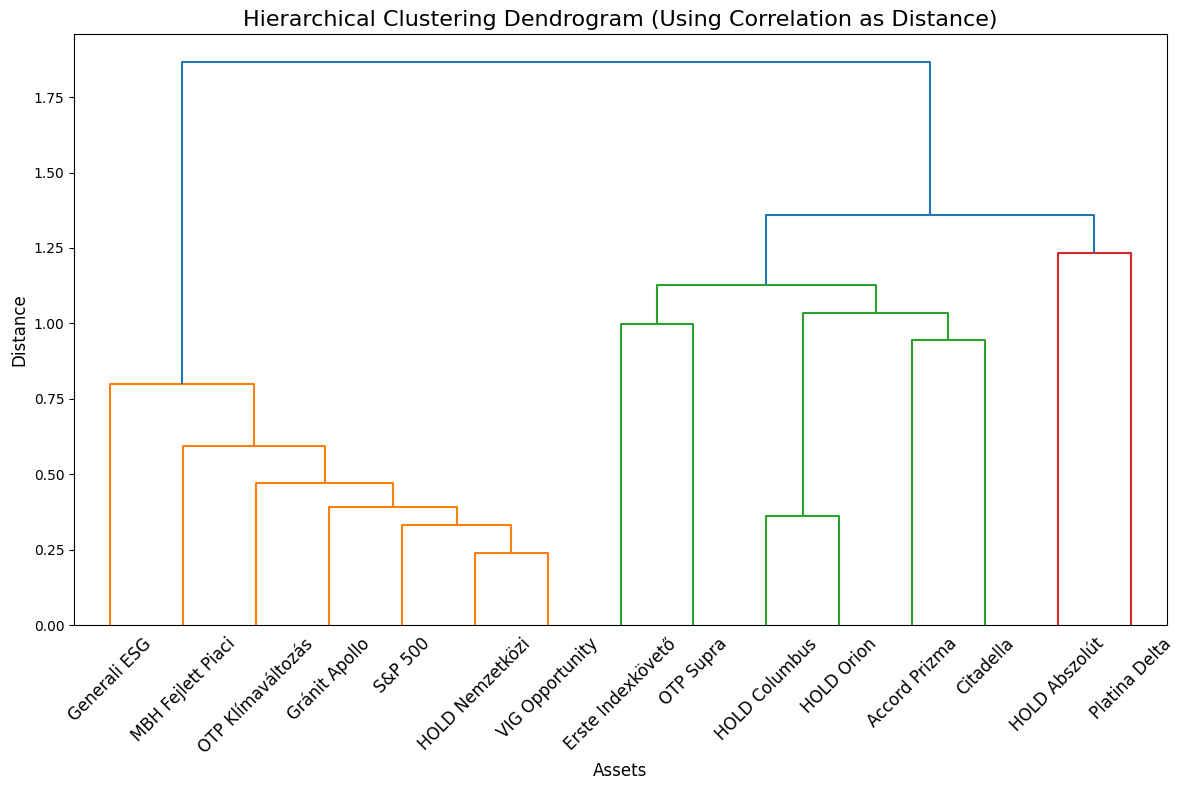

In [183]:
correlation_matrix = daily_returns.corr()
distance_matrix = 1 - correlation_matrix
linked = sch.linkage(distance_matrix, method='average')
plt.figure(figsize=(12, 8))
sch.dendrogram(linked, labels=correlation_matrix.columns, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (Using Correlation as Distance)', fontsize=16)
plt.xlabel('Assets', fontsize=12, )
plt.xticks(rotation=45,)
plt.ylabel('Distance', fontsize=12)
plt.tight_layout()
plt.show()

In [184]:
df.index = pd.to_datetime(df.index)
yearly_returns = df.resample('Y').last().pct_change().dropna()
average_yearly_returns = yearly_returns.mean()
std_dev_yearly_returns = yearly_returns.std()
sharpe_ratios_yearly = (average_yearly_returns - annual_risk_free_rate) / std_dev_yearly_returns
sharpe_ratios_yearly_df = pd.DataFrame({
    'Average Yearly Return': average_yearly_returns,
    'Standard Deviation of Yearly Returns': std_dev_yearly_returns,
    'Yearly Sharpe Ratio': sharpe_ratios_yearly
})
sharpe_ratios_yearly_df

C:\Users\takat\AppData\Local\Temp\ipykernel_33328\4291094125.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_returns = df.resample('Y').last().pct_change().dropna()


Average Yearly Return  \
Gránit Apollo                   0.109606   
Erste Indexkövető               0.120602   
Generali ESG                    0.093536   
MBH Fejlett Piaci               0.142755   
OTP Klímaváltozás               0.121249   
OTP Supra                      -0.019800   
HOLD Columbus                   0.092036   
HOLD Nemzetközi                 0.143427   
HOLD Abszolút                   0.024955   
HOLD Orion                      0.115020   
VIG Opportunity                 0.136130   
Accord Prizma                   0.048748   
Platina Delta                   0.160281   
Citadella                       0.045040   
S&P 500                         0.215307   

                   Standard Deviation of Yearly Returns  Yearly Sharpe Ratio  
Gránit Apollo                                  0.096437             0.929168  
Erste Indexkövető                              0.210348             0.478266  
Generali ESG                                   0.098484             0.746678  
MBH Fejlett Piaci                              0.152397             0.805492  
OTP Klímaváltozás                              0.294363             0.343960  
OTP Supra                                      0.197055            -0.201977  
HOLD Columbus                                  0.057102             1.261530  
HOLD Nemzetközi                                0.113608             1.086433  
HOLD Abszolút                                  0.059411             0.083407  
HOLD Orion                                     0.119091             0.797877  
VIG Opportunity                                0.125107             0.928248  
Accord Prizma                                  0.062434             0.460455  
Platina Delta                                  0.172597             0.812767  
Citadella                                      0.087877             0.284948  
S&P 500                                        0.173631             1.124841

C:\Users\takat\AppData\Local\Temp\ipykernel_33328\1685487539.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = df.resample('M').last().pct_change().dropna()


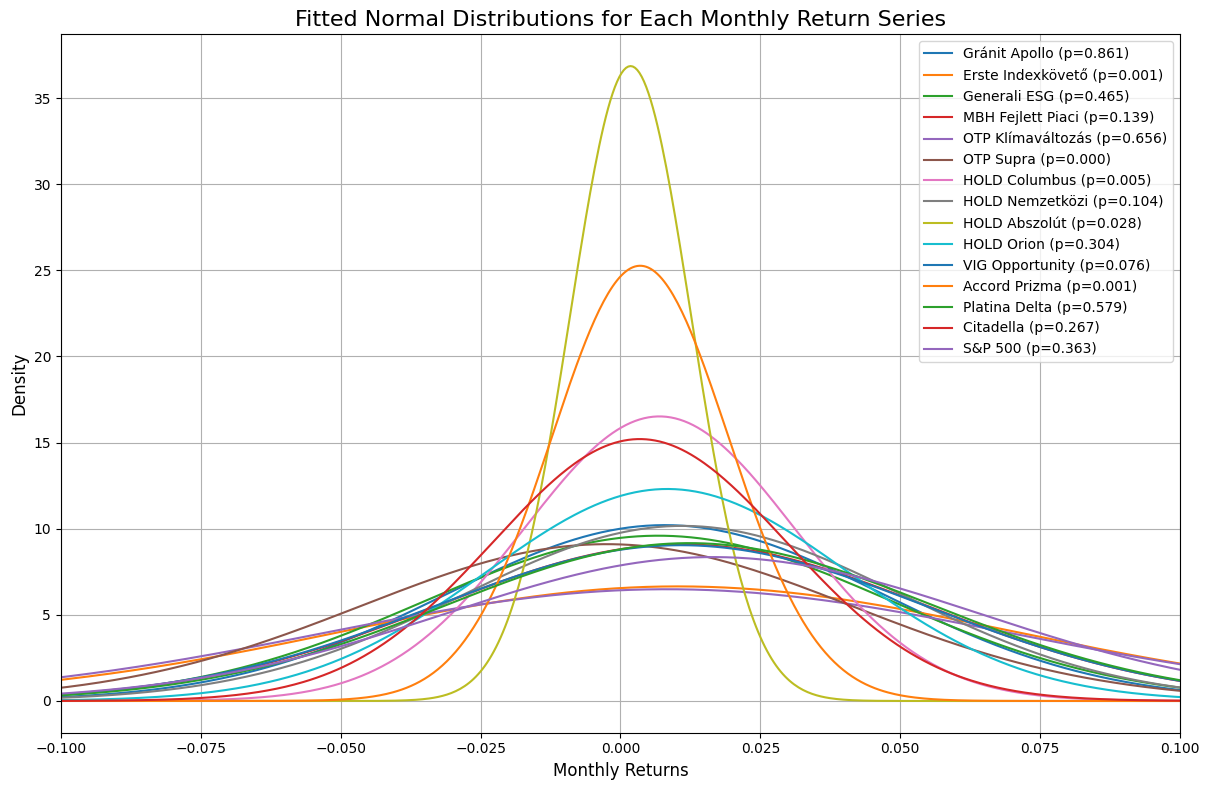

{'Gránit Apollo': {'W-statistic': 0.99085533618927,
  'p-value': 0.861415684223175,
  'is_normal': True},
 'Erste Indexkövető': {'W-statistic': 0.9405648708343506,
  'p-value': 0.0013252809876576066,
  'is_normal': False},
 'Generali ESG': {'W-statistic': 0.9843506217002869,
  'p-value': 0.46495333313941956,
  'is_normal': True},
 'MBH Fejlett Piaci': {'W-statistic': 0.9753095507621765,
  'p-value': 0.13897816836833954,
  'is_normal': True},
 'OTP Klímaváltozás': {'W-statistic': 0.987492561340332,
  'p-value': 0.656167209148407,
  'is_normal': True},
 'OTP Supra': {'W-statistic': 0.8027635812759399,
  'p-value': 9.104059728315406e-09,
  'is_normal': False},
 'HOLD Columbus': {'W-statistic': 0.9513137340545654,
  'p-value': 0.005093146115541458,
  'is_normal': False},
 'HOLD Nemzetközi': {'W-statistic': 0.9732321500778198,
  'p-value': 0.10355480760335922,
  'is_normal': True},
 'HOLD Abszolút': {'W-statistic': 0.9640917778015137,
  'p-value': 0.028465593233704567,
  'is_normal': False}

In [185]:
monthly_returns = df.resample('M').last().pct_change().dropna()
shapiro_test_results_monthly = {}
x = np.linspace(-0.2, 0.2, 1000)
plt.figure(figsize=(12, 8))
for column in monthly_returns.columns:
    try:
        returns = monthly_returns[column].dropna()
        W, p_value = shapiro(returns)
        shapiro_test_results_monthly[column] = {
            'W-statistic': W,
            'p-value': p_value,
            'is_normal': p_value > 0.05
        }
        mu, std = norm.fit(returns)
        fitted_curve = norm.pdf(x, mu, std)
        plt.plot(x, fitted_curve, label=f"{column} (p={p_value:.3f})")
    except Exception as e:
        shapiro_test_results_monthly[column] = {
            'W-statistic': None,
            'p-value': None,
            'is_normal': False,
            'error': str(e)
        }
plt.title('Fitted Normal Distributions for Each Monthly Return Series', fontsize=16)
plt.xlabel('Monthly Returns', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(-0.1,0.1)
plt.show()
shapiro_test_results_monthly

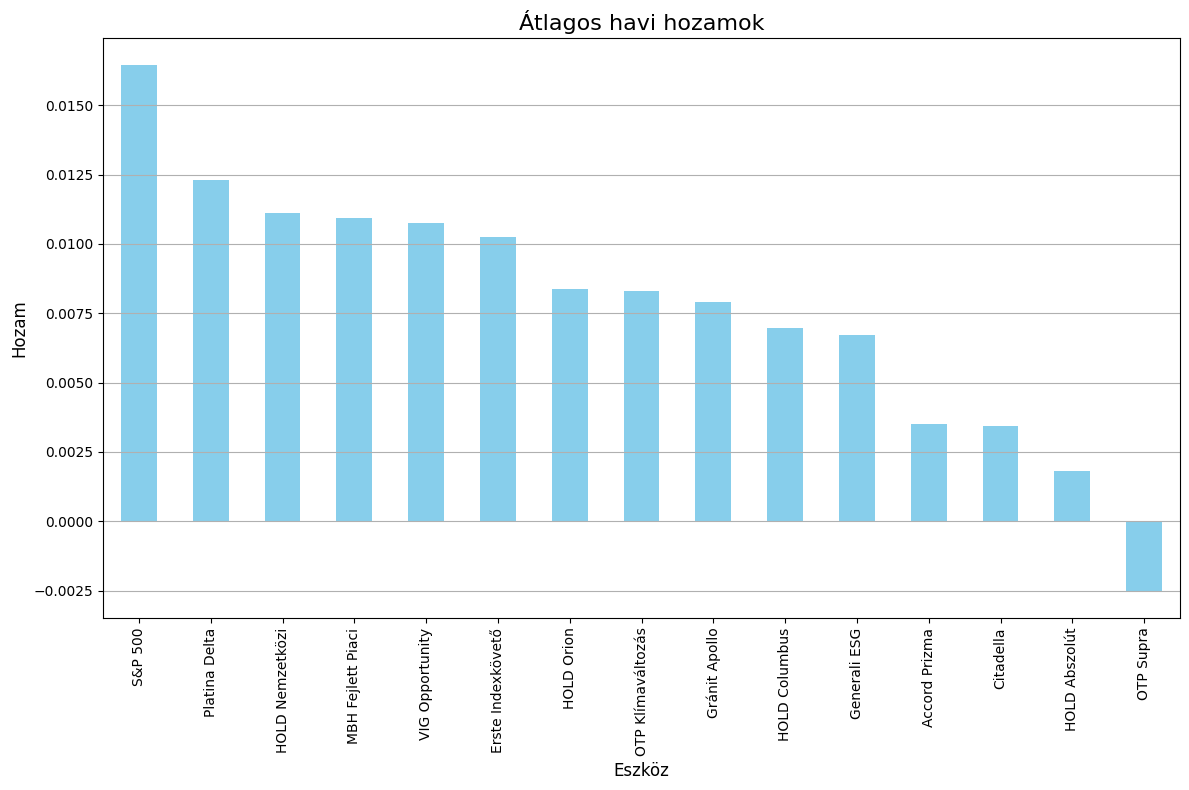

In [186]:
monthly_means = monthly_returns.mean()
draw_decreasing_barchart(monthly_means, 'Átlagos havi hozamok', 'Eszköz', 'Hozam')

Max Drawdowns:
 Gránit Apollo       -0.261444
Erste Indexkövető   -0.394811
Generali ESG        -0.311816
MBH Fejlett Piaci   -0.274339
OTP Klímaváltozás   -0.308348
OTP Supra           -0.513646
HOLD Columbus       -0.128872
HOLD Nemzetközi     -0.296252
HOLD Abszolút       -0.114519
HOLD Orion          -0.187569
VIG Opportunity     -0.319097
Accord Prizma       -0.093234
Platina Delta       -0.256997
Citadella           -0.205072
S&P 500             -0.309207
dtype: float64
Calmar Ratios:
 Gránit Apollo        0.355593
Erste Indexkövető    0.308920
Generali ESG         0.260632
MBH Fejlett Piaci    0.482770
OTP Klímaváltozás    0.305818
OTP Supra           -0.087683
HOLD Columbus        0.710569
HOLD Nemzetközi      0.477715
HOLD Abszolút        0.201246
HOLD Orion           0.555640
VIG Opportunity      0.399178
Accord Prizma        0.453043
Platina Delta        0.583799
Citadella            0.208056
S&P 500              0.679008
dtype: float64
Recovery Times:
 Gránit Apollo        

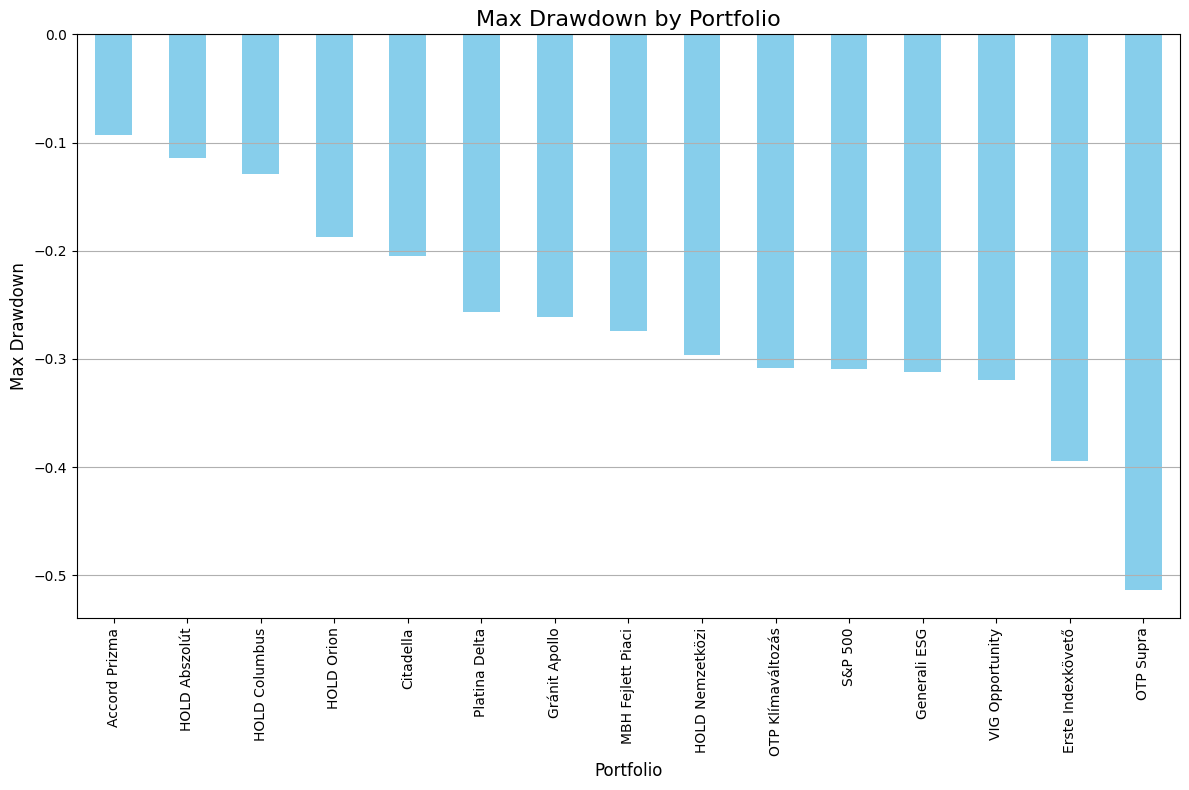

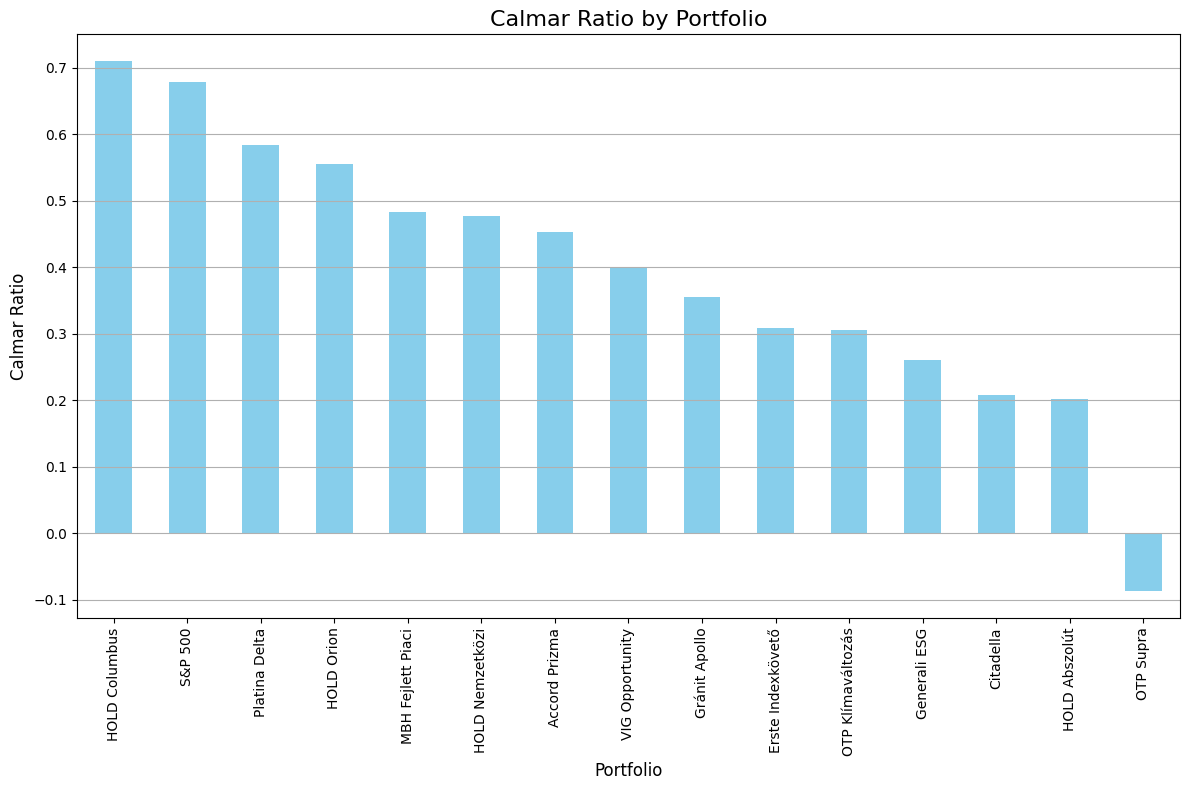

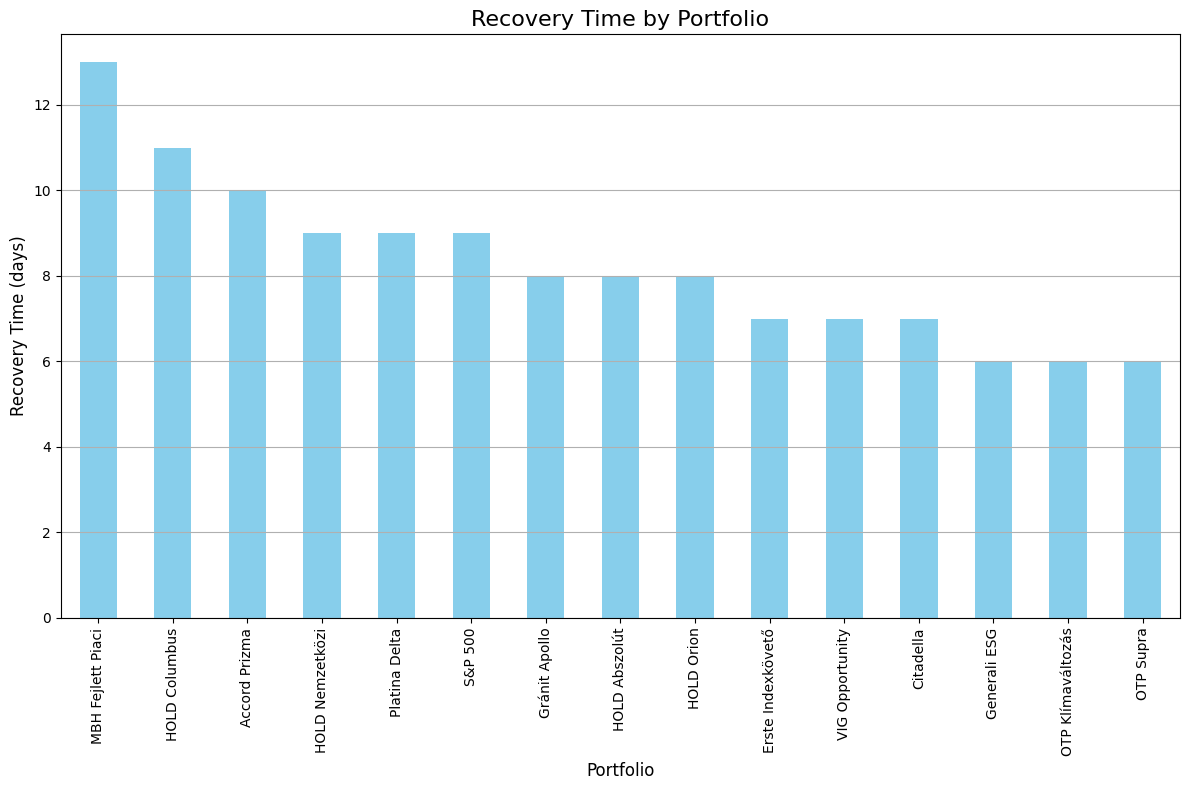

In [187]:

def max_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown_value = drawdown.min()
    return max_drawdown_value

# Apply the Max Drawdown function to each portfolio
max_drawdowns = daily_returns.apply(max_drawdown)
print("Max Drawdowns:\n", max_drawdowns)

# 2. Calmar Ratio
def calmar_ratio(annualized_return, max_drawdown):
    return annualized_return / abs(max_drawdown)

# Calculate the annualized return for each portfolio
annualized_returns = daily_returns.mean() * 252

# Apply the Calmar Ratio function to each portfolio
calmar_ratios = pd.Series({col: calmar_ratio(annualized_returns[col], max_drawdowns[col]) for col in daily_returns.columns})
print("Calmar Ratios:\n", calmar_ratios)

# 3. Recovery Time Analysis
def recovery_time(returns):
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    recovery_time = (drawdown == 0).astype(int).groupby(drawdown.ne(0).cumsum()).cumsum().max()
    return recovery_time

# Apply the Recovery Time function to each portfolio
recovery_times = daily_returns.apply(recovery_time)
print("Recovery Times:\n", recovery_times)

# Visualization
draw_decreasing_barchart(max_drawdowns, "Max Drawdown by Portfolio", "Portfolio", "Max Drawdown")
draw_decreasing_barchart(calmar_ratios, "Calmar Ratio by Portfolio", "Portfolio", "Calmar Ratio")
draw_decreasing_barchart(recovery_times, "Recovery Time by Portfolio", "Portfolio", "Recovery Time (days)")


17


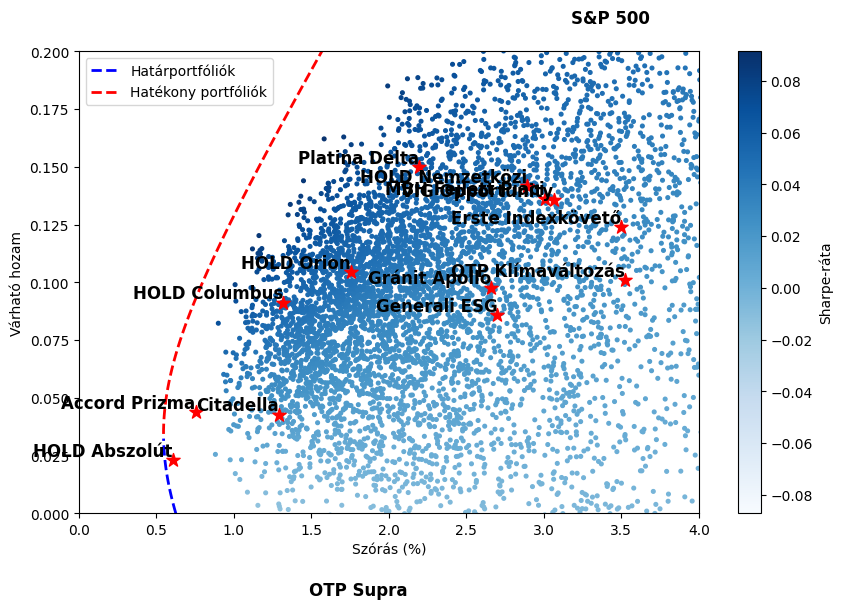

In [188]:
def calculate_returns(data):
    return data.pct_change().dropna()

def portfolio_statistics(weights, returns, covariance):
    portfolio_return = np.dot(weights, returns.mean()) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance, weights))) * np.sqrt(252)  # Annualized volatility
    return portfolio_return, portfolio_volatility

def efficient_frontier(returns, num_portfolios, risk_free_rate):
    cov_matrix = returns.cov() * 252  # Annualize the covariance matrix
    expected_returns = returns.mean() * 252  # Annualize the returns
    num_assets = len(expected_returns)
    results = np.zeros((4, num_portfolios))

    for i in range(num_portfolios):
        weights = np.random.randn(num_assets)*1000
        weights /= np.sum(weights)        
        portfolio_return, portfolio_volatility = portfolio_statistics(weights, returns, cov_matrix)
        results[0,i] = portfolio_volatility
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_volatility  # Sharpe ratio

    return results

def minimum_variance_portfolio(cov_matrix):
    num_assets = len(cov_matrix)
    args = (cov_matrix,)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, cov: np.dot(weights.T, np.dot(cov, weights)),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def market_portfolio(returns, covariance, risk_free_rate):
    num_assets = len(returns)
    args = (returns, covariance, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(lambda weights, returns, cov, rf: -(np.dot(weights, returns) - rf) / np.sqrt(np.dot(weights.T, np.dot(cov, weights))),
                      num_assets * [1. / num_assets,],
                      args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

def plot_efficient_frontier(results, exact_frontier_returns, exact_frontier_volatilities, 
                            mvp_return, mvp_volatility, market_return, market_volatility, 
                            risk_free_rate, min_x, max_x, min_y, max_y,returns, tickers):
    plt.figure(figsize=(10, 6))
    plt.xlim(min_x, max_x )  # Volatility range
    plt.ylim(min_y, max_y )  # Expected return range

    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='Blues', marker='o', s=7, alpha=1)
    plt.colorbar(label='Sharpe-ráta')
    min_vol =  np.array(exact_frontier_volatilities).min()
    min_vol_pos = np.where(np.array(exact_frontier_volatilities) == min_vol)[0][0]
    print(min_vol_pos)
    plt.plot(exact_frontier_volatilities[:min_vol_pos], exact_frontier_returns[:min_vol_pos], 'b--', label='Határportfóliók', linewidth=2)
    
    plt.plot(exact_frontier_volatilities[min_vol_pos:], exact_frontier_returns[min_vol_pos:], 'r--', label='Hatékony portfóliók', linewidth=2)
    for tick in tickers:
       
        plt.scatter(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, color='red', marker='*', s=100, zorder=2, )
        plt.text(np.sqrt(returns[tick].var())* 252, returns[tick].mean()* 252, tick, fontsize=12, fontweight="bold", verticalalignment='bottom', horizontalalignment='right', color='black')

    plt.xlabel('Szórás (%)')
    plt.ylabel('Várható hozam')
    plt.legend()

num_portfolios=10000
min_x, max_x = 0, 4
min_y, max_y = 0.0, 0.2
tickers = df.columns
returns = calculate_returns(df)
results = efficient_frontier(returns, num_portfolios, annual_risk_free_rate)
mu = returns.mean() * 252  
Sigma = returns.cov() * 252  
Sigma_inv = np.linalg.inv(Sigma)
ones = np.ones(len(mu))
U = np.vstack([mu, ones]).T
M = U.T@ (Sigma_inv@ U)
M_inv = np.linalg.inv(M)
desired_returns = np.linspace(min_y, max_y , 100)
exact_weights_list = []
exact_risk_list = []

for desired_return in desired_returns:
    u = np.array([desired_return, 1])
    w_star = Sigma_inv@ U@ M_inv@u
    # print(w_star)
    portfolio_risk = np.sqrt(np.dot(w_star.T, np.dot(Sigma, w_star))) * np.sqrt(252)
    exact_weights_list.append(w_star)
    exact_risk_list.append(portfolio_risk)

mvp_weights = minimum_variance_portfolio(Sigma)
mvp_return, mvp_volatility = portfolio_statistics(mvp_weights, returns, Sigma)
market_weights = market_portfolio(mu, Sigma, annual_risk_free_rate)
market_return, market_volatility = portfolio_statistics(market_weights, returns, Sigma)
plot_efficient_frontier(results, desired_returns, exact_risk_list, mvp_return, mvp_volatility, market_return, market_volatility, annual_risk_free_rate, min_x, max_x, min_y, max_y, returns, tickers)

plt.show()
